In [1]:
import itertools
import os
import collections
import sys
import traceback
import matplotlib
import numpy as np
import re
import glypy
from glypy import monosaccharides, glycans, motifs
from glypy.composition import Composition, composition_transform, glycan_composition
from glypy.structure import (glycan, monosaccharide, substituent,
                              Anomer, Configuration, SuperClass,
                              Substituent, Glycan, Monosaccharide,
                              crossring_fragments)
from glypy.composition import glycan_composition
from glypy.composition.glycan_composition import GlycanComposition, MonosaccharideResidue, FrozenGlycanComposition, FrozenMonosaccharideResidue
from glypy.io.nomenclature import identity
from glypy.io import glycoct, glycomedb, iupac, glyspace
from glypy import plot
from glypy.algorithms import subtree_search, similarity, database
from glypy.tests import common as tests
%matplotlib inline
from IPython.display import set_matplotlib_formats, display

set_matplotlib_formats("svg")

import logging
logging.basicConfig(level="DEBUG")
from matplotlib import pyplot as plt
from matplotlib import transforms

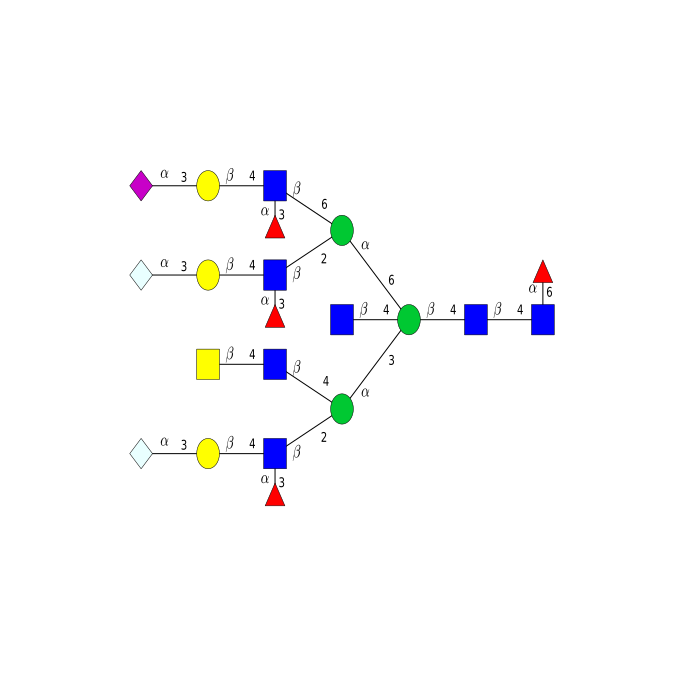

In [6]:
dt, ax = plot.plot(tests.load("complex_glycan"), layout='balanced', orientation='h', label=True, fontsize=6)
#dt.transform(transforms.Affine2D().scale(3))
#ax.set_ylim(2.5 * i for i in ax.get_ylim())
#ax.set_xlim(2.5 * i for i in ax.get_xlim())
fig = ax.get_figure()
fig.set_figwidth(12)
fig.set_figheight(12)
ax.autoscale_view()

fig.savefig("balanced_layout.png")

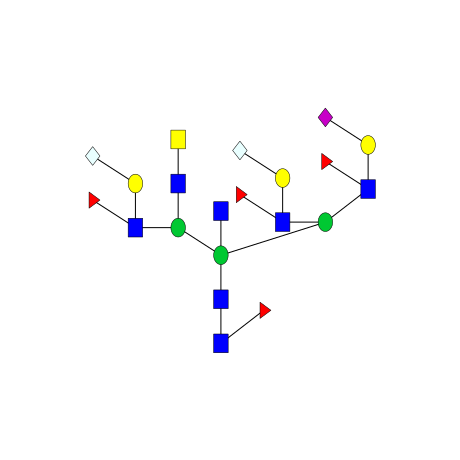

In [34]:
dt, ax = plot.plot(tests.load("complex_glycan"), layout='topological', orientation='v', label=False, fontsize=6)
#dt.transform(transforms.Affine2D().scale(3))
#ax.set_ylim(2.5 * i for i in ax.get_ylim())
#ax.set_xlim(2.5 * i for i in ax.get_xlim())
fig = ax.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
#ax.autoscale_view()
fig.savefig("topological_layout.png")

dt, ax = plot.plot(tests.load("complex_glycan"), orientation="h")
dt.transform(matplotlib.transforms.Affine2D().scale(4))
fig = ax.get_figure()

minx, maxx, miny, maxy = dt.extrema()
print minx, maxx, miny, maxy
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 5, maxy + 5)

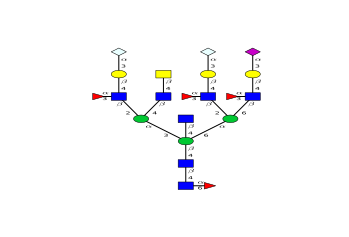

In [8]:
sx = 1.2
sy = 1.2

dt, ax = plot.plot(tests.load("complex_glycan"), layout='balanced', orientation='v', label=True, fontsize=7)
#dt.transform(matplotlib.transforms.Affine2D().scale(1, 1.5))
#ax.set_xlim((i * sx for i in ax.get_xlim()))
#ax.set_ylim((i * sy for i in ax.get_ylim()))

#display(ax.get_figure())

#for nodes, text_maps in (dt.data['text']).items():
#    for text_bunch in text_maps['linkage']:
#        parent_patch = dt.data['patches'][nodes[0]]
#        child_patch = dt.data["patches"][nodes[1]]
#        for text in text_bunch:
#            bb_patch = text.get_position(), text.get_window_extent()
#            print bb_patch


#fig = ax.get_figure()
#fig.set_figwidth(8)
#fig.set_figheight(8)

#sx = 1
#sy = 1
#dt, ax = plot.plot(tests.load("complex_glycan"), layout='topological', orientation='h', label=True, fontsize=7)
#dt.transform(matplotlib.transforms.Affine2D().scale(sx, sy))

#ax.set_xlim((i * sx for i in ax.get_xlim()))
#ax.set_ylim((i * sy for i in ax.get_ylim()))


In [9]:
from glypy import enzymes

In [10]:
enz = enzymes.Glycosyltransferase(3, 1, Anomer.beta, monosaccharides.GlcNAc, monosaccharides.GlcNAc)

In [11]:
g = Glycan(monosaccharides.GlcNAc)

RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n
RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
LIN
1:1d(2+1)2n
2:1o(3+1)3d
3:3d(2+1)4n



(RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n: id=307118556448272064417929033134026285599  x=0.0 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0xb864f98>)

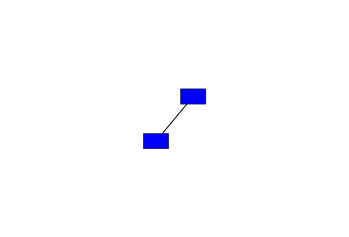

In [12]:
for x in enz.traverse(g):
    print x
    enz.apply(x)
print g
plot.plot(g, layout='topological')

In [13]:
ase = enzymes.Glycosidase(3, 1, anomer=Anomer.beta, parent=None, child=monosaccharides.GlcNAc)

In [43]:
query = r'''
select distinct ?saccharide ?glycoct where {
        ?saccharide a glycan:saccharide .
        ?saccharide glycan:has_glycosequence ?sequence .
        FILTER(CONTAINS(str(?sequence), "glycoct")) .
        ?sequence glycan:has_sequence ?glycoct .
        ?saccharide glycan:has_motif glycoinfo:G00026MO
}
'''
r = glyspace.query(query)

In [67]:
structures = {}
has_repeats = {}
j = i = 0
for acc, glycoct_str in r:
    try:
        i += 1
        structures[str(acc)] = glycoct.loads(glycoct_str)
        if "REP" in glycoct_str:
            has_repeats[str(acc)] = glycoct_str
    except glycoct.GlycoCTError, e:
        # print e
        j += 1

In [169]:
from collections import defaultdict

In [200]:
dd = defaultdict(list)
masses = defaultdict(list)
has_sulfate = similarity.functools.partial(similarity.has_substituent, substituent="sulfate")

def is_sulfated(glycan):
    return any(map(has_sulfate, glycan))

for acc, structure in structures.items():
    if is_sulfated(structure):
        continue
    c = GlycanComposition.from_glycan(structure)
    c.drop_stems()
    c.drop_positions()
    s = str(c)
    short = False
    for g in ["Kdn", "Neu5NGc", "dHex", "Phos", 'Me', "Pen", "Sug"]:
        if g in s:
            short = True
            break
    if short:
        continue
    dd[s].append(acc)
    masses[round(c.mass())].append(acc)

```sparql
SELECT DISTINCT ?saccharide ?glycoct WHERE {
        ?saccharide a glycan:saccharide .
        ?saccharide glycan:has_glycosequence ?sequence .
        FILTER CONTAINS(str(?sequence), "glycoct") .
        ?sequence glycan:has_sequence ?glycoct .
        ?saccharide glycan:has_motif glycoinfo:G00026MO
}
```

In [201]:
(dd.keys())

715

In [204]:
{k: len(v) for k, v in (masses).items()}

{910.0: 5,
 1056.0: 8,
 1072.0: 31,
 1113.0: 23,
 1202.0: 3,
 1218.0: 11,
 1234.0: 43,
 1259.0: 26,
 1275.0: 40,
 1316.0: 34,
 1364.0: 3,
 1380.0: 5,
 1396.0: 67,
 1406.0: 10,
 1422.0: 30,
 1438.0: 29,
 1463.0: 41,
 1479.0: 41,
 1520.0: 32,
 1525.0: 1,
 1527.0: 1,
 1543.0: 4,
 1559.0: 70,
 1567.0: 20,
 1568.0: 12,
 1584.0: 17,
 1600.0: 13,
 1608.0: 2,
 1609.0: 10,
 1625.0: 35,
 1641.0: 63,
 1666.0: 30,
 1682.0: 38,
 1687.0: 2,
 1705.0: 5,
 1713.0: 22,
 1714.0: 1,
 1721.0: 73,
 1723.0: 36,
 1729.0: 10,
 1730.0: 3,
 1746.0: 7,
 1754.0: 1,
 1755.0: 3,
 1762.0: 5,
 1770.0: 16,
 1771.0: 7,
 1787.0: 70,
 1803.0: 16,
 1812.0: 4,
 1828.0: 38,
 1844.0: 30,
 1849.0: 2,
 1858.0: 1,
 1859.0: 1,
 1867.0: 1,
 1869.0: 27,
 1875.0: 4,
 1876.0: 1,
 1883.0: 61,
 1885.0: 23,
 1890.0: 4,
 1891.0: 18,
 1892.0: 1,
 1899.0: 1,
 1908.0: 2,
 1916.0: 21,
 1917.0: 1,
 1924.0: 3,
 1926.0: 29,
 1932.0: 34,
 1933.0: 26,
 1949.0: 18,
 1957.0: 2,
 1965.0: 17,
 1973.0: 12,
 1974.0: 16,
 1990.0: 47,
 2004.0: 2,
 2005.0

In [205]:
import pandas as pd

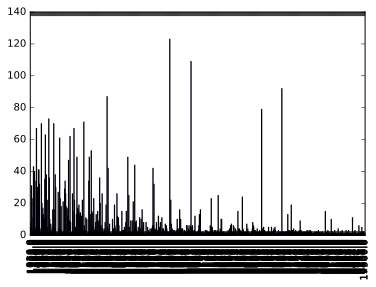

In [207]:
pd.Series({k: len(v) for k, v in (masses).items()}).plot(kind='bar')

In [213]:
pd.Series({k: len(v) for k, v in (dd).items()}).sum()

4804L

In [211]:
len(dd)

715

In [217]:
ur = glyspace.NSGlycoinfo.G00026MO

In [220]:
glyspace.client.qname(ur)

u'glycoinfo:G00026MO'

In [232]:
reload(glyspace)

<module 'glypy.io.glyspace' from 'd:\dropbox\glycomicssandbox\glypy\glypy\io\glyspace.py'>

In [233]:
r = glyspace.client.structures_with_motif(ur)

In [234]:
r[0]

ReferenceEntity
source: [a rdflib:ConjunctiveGraph;rdflib:storage [a rdflib:Store;rdfs:label 'SPARQLStore']]
glycoct: RES
1b:x-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9b:b-dgal-HEX-1:5
10b:b-dglc-HEX-1:5
11s:n-acetyl
12b:a-lgal-HEX-1:5|6:d
13b:b-dgal-HEX-1:5
14b:a-dman-HEX-1:5
15b:b-dglc-HEX-1:5
16s:n-acetyl
17b:b-dgal-HEX-1:5
18b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3|6+1)6d
6:6o(2+1)7d
7:7d(2+1)8n
8:7o(4+1)9d
9:6o(4+1)10d
10:10d(2+1)11n
11:10o(3+1)12d
12:10o(4+1)13d
13:5o(3|6+1)14d
14:14o(2+1)15d
15:15d(2+1)16n
16:15o(4+1)17d
17:1o(6+1)18d
UND
UND1:100.0:100.0
ParentIDs:9|13|17
SubtreeLinkageID1:o(6+1)d
RES
19b:a-dgro-dgal-NON-2:6|1:a|2:keto|3:d
20s:n-acetyl
LIN
18:19d(5+1)20n

In [240]:
monosaccharide.depth(tests.load("complex_glycan").root)

7

In [231]:
glyspace.split_uri(u'http://rdf.glycoinfo.org/glycan/G13991MC')

(u'http://rdf.glycoinfo.org/glycan/', u'G13991MC')

In [66]:
txt = '''
RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7r:r1
8b:b-dglc-HEX-1:5
9s:n-acetyl
10b:b-dgal-HEX-1:5
11b:a-lgal-HEX-1:5|6:d
12b:a-dman-HEX-1:5
13r:r2
14b:b-dglc-HEX-1:5
15s:n-acetyl
16b:b-dgal-HEX-1:5
17b:a-lgal-HEX-1:5|6:d
18b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:6o(2+1)7n
7:7n(3+1)8d
8:8d(2+1)9n
9:8o(4+1)10d
10:10o(2+1)11d
11:5o(6+1)12d
12:12o(2+1)13n
13:13n(3+1)14d
14:14d(2+1)15n
15:14o(4+1)16d
16:16o(2+1)17d
17:1o(6+1)18d
REP
REP1:24o(3+1)19d=-1--1
RES
19b:b-dglc-HEX-1:5
20s:n-acetyl
21b:b-dgal-HEX-1:5
22b:b-dglc-HEX-1:5
23s:n-acetyl
24b:b-dgal-HEX-1:5
LIN
18:19d(2+1)20n
19:19o(4+1)21d
20:21o(3|6+1)22d
21:22d(2+1)23n
22:22o(4+1)24d
REP2:30o(3+1)25d=-1--1
RES
25b:b-dglc-HEX-1:5
26s:n-acetyl
27b:b-dgal-HEX-1:5
28b:b-dglc-HEX-1:5
29s:n-acetyl
30b:b-dgal-HEX-1:5
LIN
23:25d(2+1)26n
24:25o(4+1)27d
25:27o(3|6+1)28d
26:28d(2+1)29n
27:28o(4+1)30d


RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7r:r1
8b:b-dglc-HEX-1:5
9s:n-acetyl
10b:b-dgal-HEX-1:5
11b:a-lgal-HEX-1:5|6:d
12b:a-dman-HEX-1:5
13r:r2
14b:b-dglc-HEX-1:5
15s:n-acetyl
16b:b-dgal-HEX-1:5
17b:a-lgal-HEX-1:5|6:d
18b:a-lgal-HEX-1:5|6:d
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:6o(2+1)7n
7:7n(3+1)8d
8:8d(2+1)9n
9:8o(4+1)10d
10:10o(2+1)11d
11:5o(6+1)12d
12:12o(2+1)13n
13:13n(3+1)14d
14:14d(2+1)15n
15:14o(4+1)16d
16:16o(2+1)17d
17:1o(6+1)18d
REP
REP1:24o(3+1)19d=-1--1
RES
19b:b-dglc-HEX-1:5
20s:n-acetyl
21b:b-dgal-HEX-1:5
22b:b-dglc-HEX-1:5
23s:n-acetyl
24b:b-dgal-HEX-1:5
LIN
18:19d(2+1)20n
19:19o(4+1)21d
20:21o(3|6+1)22d
21:22d(2+1)23n
22:22o(4+1)24d
REP2:30o(3+1)25d=-1--1
RES
25b:b-dglc-HEX-1:5
26s:n-acetyl
27b:b-dgal-HEX-1:5
28b:b-dglc-HEX-1:5
29s:n-acetyl
30b:b-dgal-HEX-1:5
LIN
23:25d(2+1)26n
24:25o(4+1)27d
25:27o(3|6+1)28d
26:28d(2+1)29n
27:28o(4+1)30d'''

In [70]:
reload(glycoct)
reader = glycoct.GlycoCT(glycoct.StringIO(txt))
x = (reader).next()

In [71]:
x = list(glycoct.read(r"D:\Programming\exploration\glycresoft_sqlalchemy\human_structures.glycoct"))

(RES 1b:x-dglc-HEX-x:x 2s:n-sulfate 3s:sulfate LIN 1:1o(2+1)2n 2:1o(6+1)3n: id=1  x=0.0 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b71a6d8>)

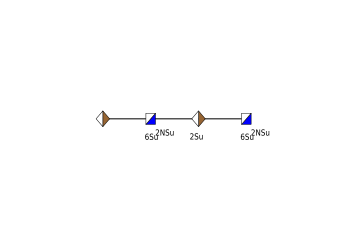

In [114]:
z = '''
RES
1b:x-dglc-HEX-x:x
2s:n-sulfate
3s:sulfate
4b:a-dido-HEX-1:5|6:a
5s:sulfate
6b:b-dglc-HEX-1:5
7s:n-sulfate
8s:sulfate
9b:a-dido-HEX-1:5|6:a
LIN
1:1o(2+1)2n
2:1o(6+1)3n
3:1o(4+1)4d
4:4o(2+-1)5n
5:4o(4+1)6d
6:6o(2+1)7n
7:6o(6+1)8n
8:6o(4+1)9d
'''

z = glycoct.loads(z)
plot.plot(z)

In [72]:
len(x)

1489

(RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n: id=1  x=3.06161699787e-17 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b4349b0>)

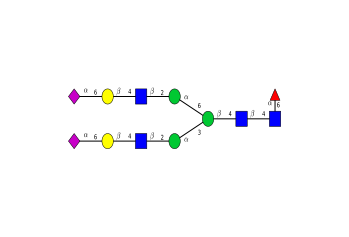

In [112]:
plot.plot(x[28], label=True)